In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import glob
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Device: grpc://10.0.0.2:8470


2023-01-21 22:04:37.452531: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-21 22:04:37.454978: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-21 22:04:37.455013: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-21 22:04:37.455043: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (287d64e0b3b9): /proc/driver/nvidia/version does not exist
2023-01-21 22:04:37.457729: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8
2.4.1


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path('chest-xray-pneumonia')
BATCH_SIZE = 64*strategy.num_replicas_in_sync
#BATCH_SIZE = 64 # for non-TPU use
IMAGE_SIZE = [180, 180]
EPOCHS = 50

In [5]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/val/*/*')))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/test/*/*')))

print(f'The total number of files is {len(filenames)}')

2023-01-21 22:05:17.918207: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-21 22:05:18.045059: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-21 22:05:18.146818: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-21 22:05:18.259137: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-21 22:05:18.344724: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


The total number of files is 5856


In [6]:
# split the data into 60:40 for train:test+val
train_files, val_test_files = train_test_split(filenames, test_size=0.4,random_state=18)

In [7]:
# split the val_test_files to 50:50 to have a final split of 60:20:20 of train:val:test
val_files, test_files = train_test_split(val_test_files, test_size=0.5, random_state=18)

In [8]:
pct_df = pd.DataFrame(columns = ['data_set', 'label', 'pct'], index = range(6))

totals = {'train':len(train_files), 'val':len(val_files), 'test':len(test_files)}

val_pneum_count = 0
val_norm_count = 0

re_pattern = '.*/(NORMAL|PNEUMONIA)/.*'

for file in val_files:
    re_match = re.match(re_pattern, file)
    if re_match[1] == 'NORMAL':
        val_norm_count += 1
    else:
        val_pneum_count += 1

pct_df.iloc[0, :] = ['val', 'NORMAL', round(100* val_norm_count / totals['val'], 1)]
pct_df.iloc[1, :] = ['val', 'PNEUMONIA', round(100* val_pneum_count / totals['val'], 1)]


test_pneum_count = 0
test_norm_count = 0
for file in test_files:
    re_match = re.match(re_pattern, file)
    if re_match[1] == 'NORMAL':
        test_norm_count += 1
    else:
        test_pneum_count += 1

pct_df.iloc[2, :] = ['test', 'NORMAL', round(100* test_norm_count / totals['test'], 1)]
pct_df.iloc[3, :] = ['test', 'PNEUMONIA', round(100* test_pneum_count / totals['test'], 1)]

train_pneum_count = 0
train_norm_count = 0
for file in train_files:
    re_match = re.match(re_pattern, file)
    if re_match[1] == 'NORMAL':
        train_norm_count += 1
    else:
        train_pneum_count += 1

pct_df.iloc[4, :] = ['train', 'NORMAL', round(100* train_norm_count / totals['train'], 1)]
pct_df.iloc[5, :] = ['train', 'PNEUMONIA', round(100* train_pneum_count / totals['train'], 1)]

In [9]:
PNEUM_COUNT = val_pneum_count + train_pneum_count + test_pneum_count
NORMAL_COUNT = val_norm_count + train_norm_count + test_norm_count
print(f'Normal: {NORMAL_COUNT}\nPneumonia: {PNEUM_COUNT}')

pct_df

Normal: 1583
Pneumonia: 4273


,data_set,label,pct
0,val,NORMAL,26.9
1,val,PNEUMONIA,73.1
2,test,NORMAL,27.6
3,test,PNEUMONIA,72.4
4,train,NORMAL,26.9
5,train,PNEUMONIA,73.1


In [10]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_files)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_files)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_files)

#view the file paths for training
print('----Training Files----')
for f in train_list_ds.take(5):
    print(f.numpy())



----Training Files----
b'gs://kds-b576da407a636f4fabbb3e24fe756421efe83d417a548d82688d689e/chest_xray/train/PNEUMONIA/person509_virus_1025.jpeg'
b'gs://kds-b576da407a636f4fabbb3e24fe756421efe83d417a548d82688d689e/chest_xray/train/PNEUMONIA/person671_bacteria_2564.jpeg'
b'gs://kds-b576da407a636f4fabbb3e24fe756421efe83d417a548d82688d689e/chest_xray/train/PNEUMONIA/person957_virus_1629.jpeg'
b'gs://kds-b576da407a636f4fabbb3e24fe756421efe83d417a548d82688d689e/chest_xray/test/PNEUMONIA/person81_bacteria_397.jpeg'
b'gs://kds-b576da407a636f4fabbb3e24fe756421efe83d417a548d82688d689e/chest_xray/train/NORMAL/IM-0500-0001.jpeg'


In [11]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
TEST_IMG_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()

print(f'Train Image Count: {TRAIN_IMG_COUNT}\nVal Image Count: {VAL_IMG_COUNT}\nTest Image Count: {TEST_IMG_COUNT}')

Train Image Count: 3513
Val Image Count: 1171
Test Image Count: 1172


2023-01-21 22:05:18.887806: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 28, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1674338718.884479299","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 28, Output num: 0","grpc_status":3}


In [12]:
# will label as 1 if pneumonia otherwise 0
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA'

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)



In [16]:
y_train = []
for image, label in train_ds.take(TRAIN_IMG_COUNT):
    y_train.append(label)
    
print('Training Counts')
print(f'Pneumonia count: {np.sum(y_train)}\nNormal count: {TRAIN_IMG_COUNT - np.sum(y_train)}')

2023-01-21 22:07:55.749488: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 3755, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1674338875.749311761","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 3755, Output num: 0","grpc_status":3}


Training Counts
Pneumonia count: 2568
Normal count: 945


In [17]:
y_val = []
for image, label in val_ds.take(VAL_IMG_COUNT):
    y_val.append(label)
    
print('Validation Counts')
print(f'Pneumonia count: {np.sum(y_val)}\nNormal count: {VAL_IMG_COUNT - np.sum(y_val)}')

Validation Counts


2023-01-21 22:09:01.005647: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 18989, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1674338941.005538731","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 18989, Output num: 0","grpc_status":3}


Pneumonia count: 856
Normal count: 315


In [18]:
y_test = []
for image, label in test_ds.take(TEST_IMG_COUNT):
    y_test.append(label)
    
print('Test Counts')
print(f'Pneumonia count: {np.sum(y_test)}\nNormal count: {TEST_IMG_COUNT - np.sum(y_test)}')



Test Counts
Pneumonia count: 849
Normal count: 323


In [19]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
            
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    
    ds = ds.repeat()
    
    ds = ds.batch(BATCH_SIZE)
    
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [20]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [21]:
weight_for_0 = (1 / NORMAL_COUNT)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / PNEUM_COUNT)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print(f'Weight for class 0: {weight_for_0:.2f}')
print(f'Weight for class 1: {weight_for_1:.2f}')

Weight for class 0: 1.11
Weight for class 1: 0.41


In [22]:
# create some metrics for comparing on test results

def precision(y_test, y_pred):
    tp, fp = 0, 0
    
    for i in range(len(y_test)):
        if y_test[i] >= 0.5 and y_pred[i] >= 0.5:
            tp += 1
        elif y_test[i] < 0.5 and y_pred[i] >= 0.5:
            fp += 1
            
    return tp / (tp + fp)

def recall(y_test, y_pred):
    tp, fn = 0, 0
    
    for i in range(len(y_test)):
        if y_test[i] >= 0.5 and y_pred[i] >= 0.5:
            tp += 1
        elif y_test[i] >= 0.5 and y_pred[i] < 0.5:
            fn += 1
            
    return tp / (tp + fn)

def f1_score(y_test, y_pred):
    numerator = precision(y_test, y_pred) * recall(y_test, y_pred)
    denominator = precision(y_test, y_pred) + recall(y_test, y_pred)
    
    return 2 * (numerator / denominator)

In [23]:
# add exponential decay to try to improve fine tuning
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

## Fine Tune Momentum
#### This is last attempt to tune a single hyperparameter to get slight improvement in performance



Batch Size: 256
Hidden Units: 4096
Learning Rate: 0.010395
1 Hidden Layer, 4096 units
S value: 31
Momentum: 0.77
Epoch 1/50
13/13 [==============================] - 54s 2s/step - loss: 0.8354 - accuracy: 0.7765 - precision: 0.9133 - recall: 0.7619 - val_loss: 6.1138 - val_accuracy: 0.6021 - val_precision: 1.0000 - val_recall: 0.4538
Epoch 2/50
13/13 [==============================] - 3s 225ms/step - loss: 0.1362 - accuracy: 0.9291 - precision: 0.9777 - recall: 0.9232 - val_loss: 0.8049 - val_accuracy: 0.8320 - val_precision: 0.9991 - val_recall: 0.7707
Epoch 3/50
13/13 [==============================] - 3s 226ms/step - loss: 0.1027 - accuracy: 0.9343 - precision: 0.9775 - recall: 0.9315 - val_loss: 0.2148 - val_accuracy: 0.9404 - val_precision: 0.9887 - val_recall: 0.9296
Epoch 4/50
13/13 [==============================] - 3s 228ms/step - loss: 0.1038 - accuracy: 0.9312 - precision: 0.9771 - recall: 0.9293 - val_loss: 0.6216 - val_accuracy: 0.8486 - val_precision: 0.9975 - val_recall

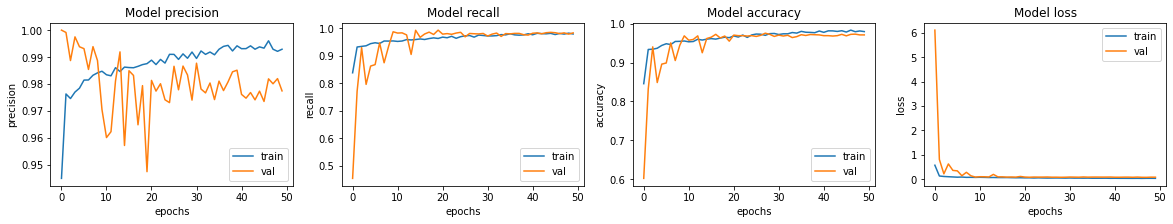

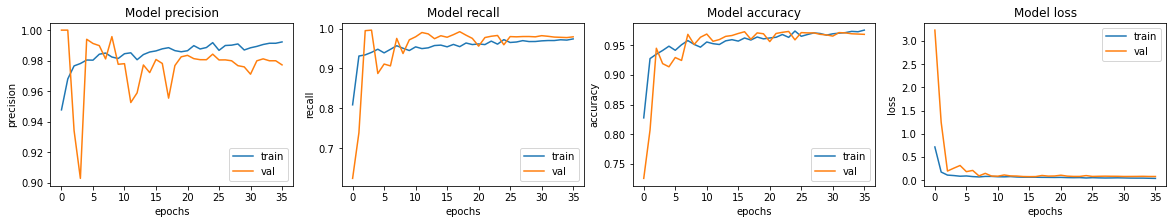

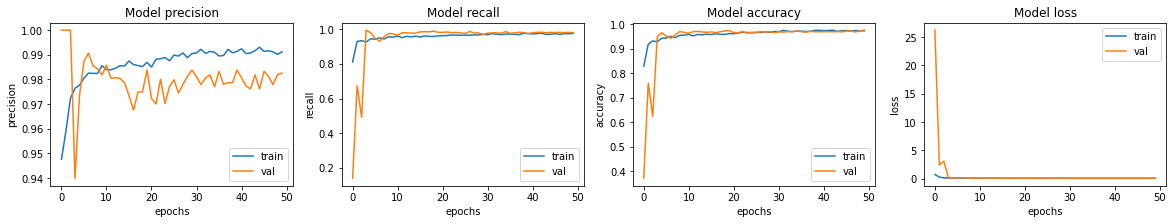

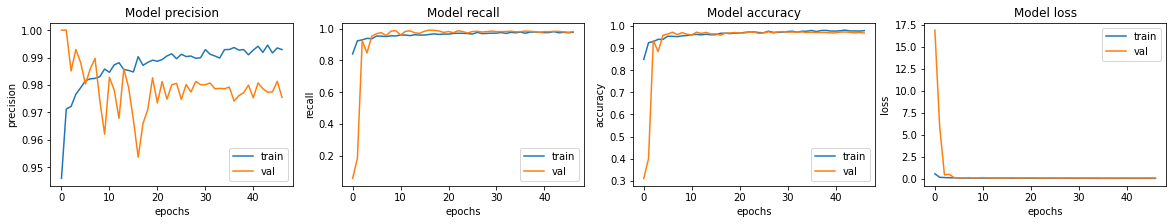

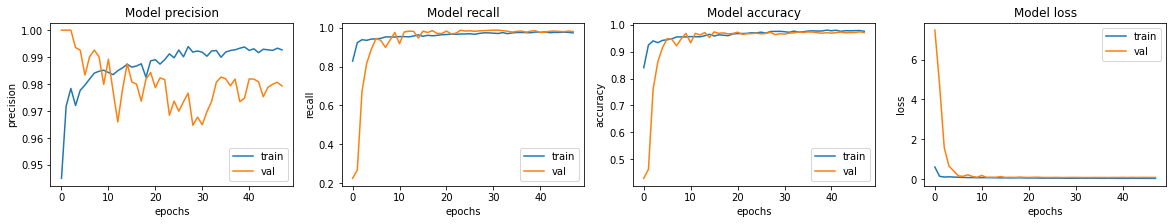

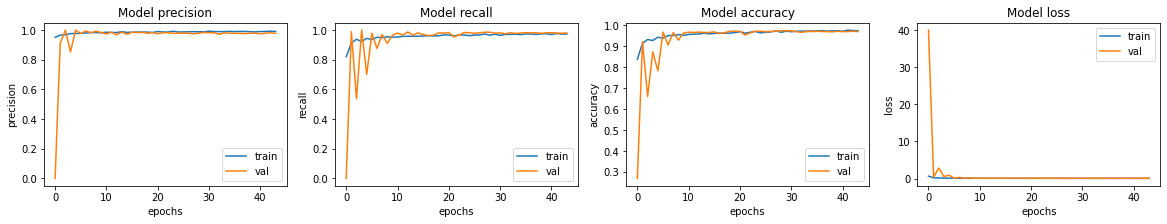

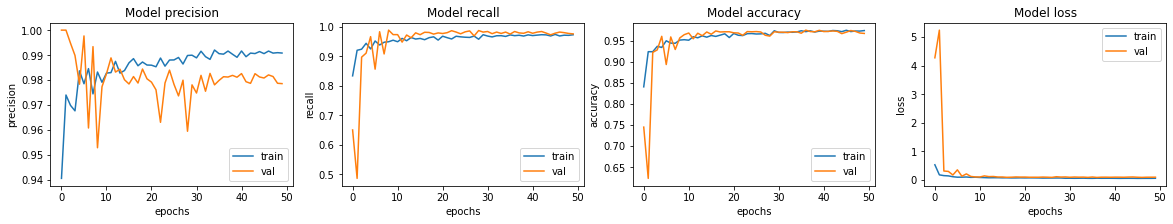

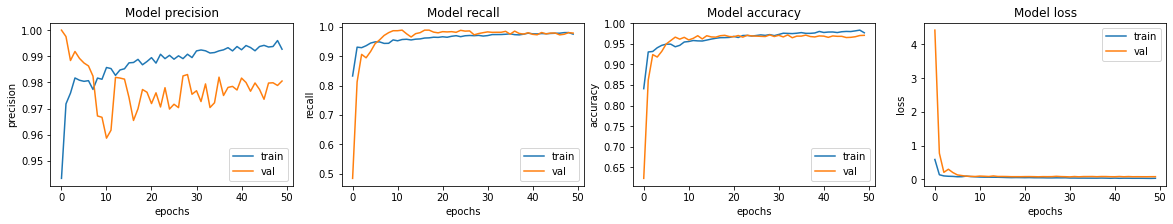

In [26]:
# use learning rate that gave best results in the learning rate hyperparameter tuning
lr = 0.010395
# use hidden_units that gave best results in the hidden units hyperparameter tuning
hidden_units = 4096
# use mini batch size that gave best results in the mini batch hyperparameter tuning
mini_batch = 32
# use the s value for the learning rate decay that was best
s = 31


# try 8 different momentum values
for _ in range(8):
    
    momentum = random.randint(70, 99) / 100
    
    BATCH_SIZE = mini_batch*strategy.num_replicas_in_sync
    print(f'\n\nBatch Size: {BATCH_SIZE}')    
    print(f'Hidden Units: {hidden_units}')
    print(f'Learning Rate: {lr}')
    print(f'1 Hidden Layer, {hidden_units} units')
    print(f'S value: {s}')
    print(f'Momentum: {momentum}')
    
    with strategy.scope():
        
        base_model = tf.keras.applications.densenet.DenseNet201(
                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                        include_top=False,
                        weights='imagenet'
                        )
        base_model.trainable = False
        
        
        
        x=base_model.output
        inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
        x = base_model(inputs, training=False)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(hidden_units, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
            
        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        model = tf.keras.Model(inputs, outputs)
        
        METRICS = [
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
                ]
        
        opt = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=momentum)
        
        model.compile(
                    optimizer=opt,
                    loss='binary_crossentropy',
                    metrics=METRICS
                     )
    
       
        checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(f"densenet_{lr}_{hidden_units}_{BATCH_SIZE}_1layer_{s}_{momentum}_xray_model.h5", save_best_only=True)
        early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
        exponential_decay_fn = exponential_decay(lr, s)
        lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
    
        history = model.fit(
                            train_ds,
                            steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
                            epochs=EPOCHS,
                            validation_data=val_ds,
                            validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
                            class_weight=class_weight,
                            callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
                            )
        
        fig, ax = plt.subplots(1, 4, figsize=(20, 3))
        ax = ax.ravel()
        
        test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
        test_ds = test_ds.batch(BATCH_SIZE)
                    
        y_preds = model.predict(test_ds, batch_size = BATCH_SIZE, verbose = True)
        y_preds = y_preds.reshape(-1)
        y_actual = [1 if x == True else 0 for x in y_test]
        
        print(f'\n\nBatch Size: {BATCH_SIZE}')    
        print(f'Hidden Units: {hidden_units}')
        print(f'Learning Rate: {lr}')
        print(f'1 Hidden Layer, {hidden_units} units')
        print(f'S value: {s}')
        print(f'Momentum: {momentum}')
        
        fpr, tpr, thresholds = roc_curve(y_actual, y_preds, pos_label=1)
        print(f'AUC score: {auc(fpr, tpr)}')
               
        print(f'Test Recall: {recall(y_actual, y_preds)}')
        print(f'Test Precision: {precision(y_actual, y_preds)}')
        print(f'Test F1 Scores: {f1_score(y_actual, y_preds)}\n\n')

        print(f"densenet_{lr}_{hidden_units}_{BATCH_SIZE}_1layer_{s}_{momentum}_xray_model")
        for i, metric in enumerate(['precision', 'recall', 'accuracy', 'loss']):
            ax[i].plot(history.history[metric])
            ax[i].plot(history.history['val_'+metric])
            ax[i].set_title(f'Model {metric}')
            ax[i].set_xlabel('epochs')
            ax[i].set_ylabel(metric)
            ax[i].legend(['train', 'val'])

## Try final random search around the known good performers



Batch Size: 256
Hidden Units: 3768
Learning Rate: 0.0114345
1 Hidden Layer, 3768 units
S value: 34
Momentum: 0.82
Epoch 1/50
13/13 [==============================] - 55s 2s/step - loss: 0.8318 - accuracy: 0.7566 - precision: 0.8984 - recall: 0.7466 - val_loss: 2.8195 - val_accuracy: 0.8267 - val_precision: 0.9965 - val_recall: 0.7666
Epoch 2/50
13/13 [==============================] - 3s 230ms/step - loss: 0.1556 - accuracy: 0.9218 - precision: 0.9760 - recall: 0.9160 - val_loss: 0.6341 - val_accuracy: 0.8906 - val_precision: 0.9930 - val_recall: 0.8557
Epoch 3/50
13/13 [==============================] - 3s 221ms/step - loss: 0.1174 - accuracy: 0.9378 - precision: 0.9751 - recall: 0.9390 - val_loss: 0.1871 - val_accuracy: 0.9409 - val_precision: 0.9271 - val_recall: 0.9973
Epoch 4/50
13/13 [==============================] - 3s 231ms/step - loss: 0.0918 - accuracy: 0.9460 - precision: 0.9757 - recall: 0.9501 - val_loss: 0.1164 - val_accuracy: 0.9600 - val_precision: 0.9890 - val_recal

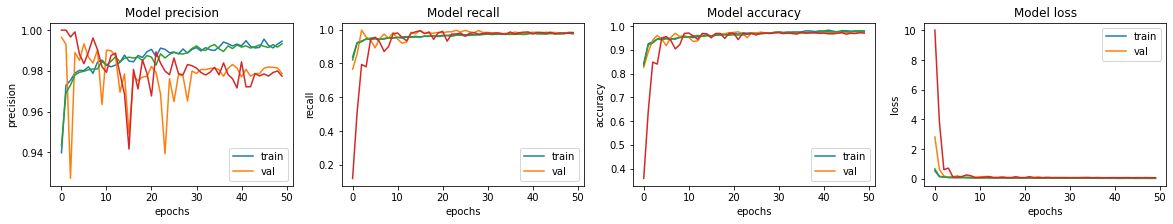

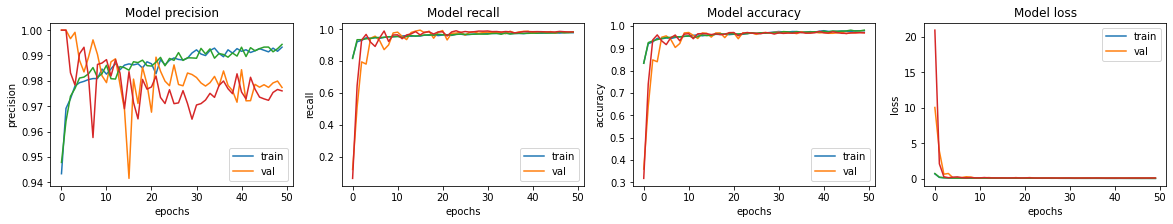

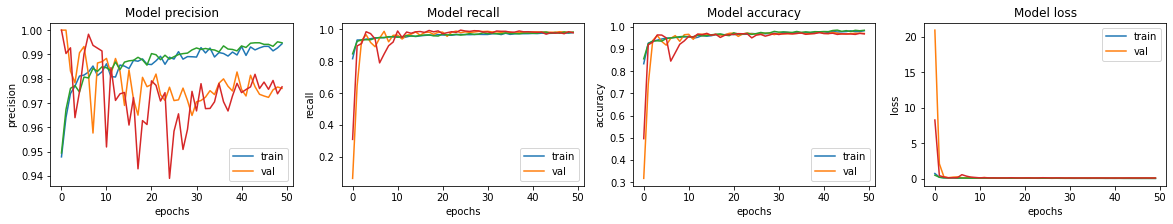

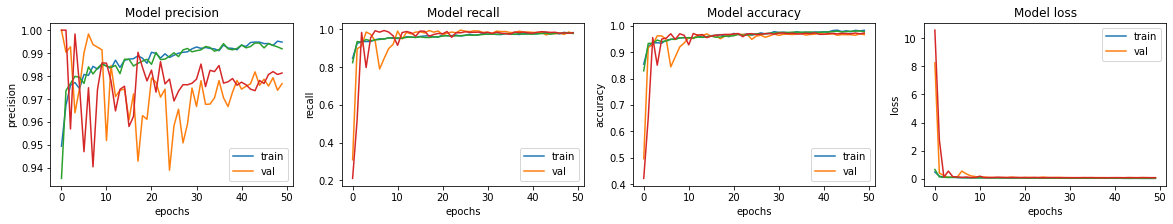

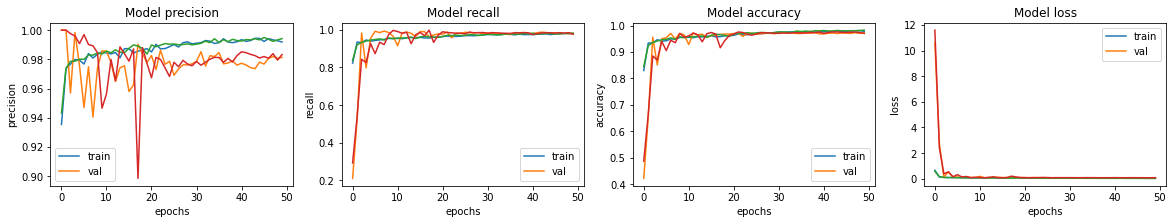

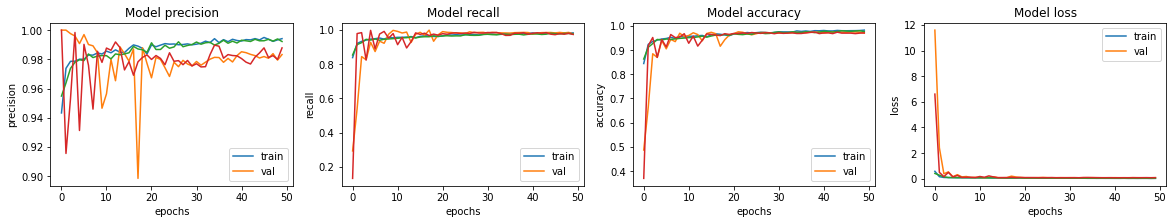

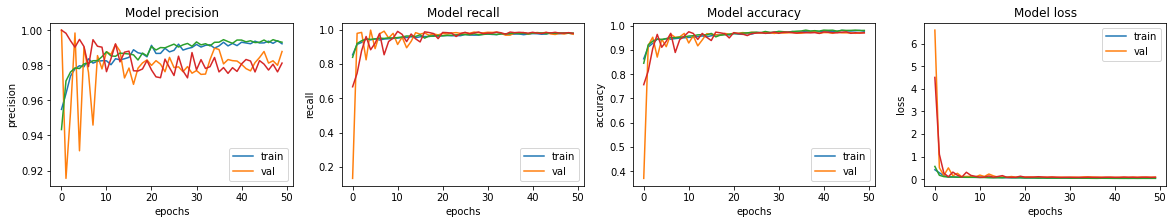

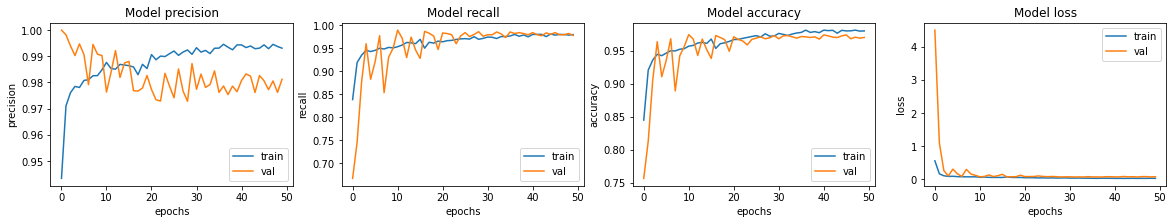

In [28]:
# use learning rate that gave best results in the learning rate hyperparameter tuning
lr = 0.010395
# use hidden_units that gave best results in the hidden units hyperparameter tuning
hidden_units = 4096
# use mini batch size that gave best results in the mini batch hyperparameter tuning
mini_batch = 32
# use the s value for the learning rate decay that was best
s = 34
# momentum that was best before
momentum = 0.82



# try 8 different combinations of hyperparameters
for _ in range(8):
    
    variation = [1 + (random.randint(-10, 10) / 100) for _ in range(2)]
    lr = lr * variation[0]
    hidden_units = (int(hidden_units * variation[1]) // 2) * 2
    
    # choose from one of three different momentums
    momentum_list = [ 0.78, 0.82, 0.86]
    mom_ind = random.randint(0, 2)
    momentum = momentum_list[mom_ind]
    
    
    BATCH_SIZE = mini_batch*strategy.num_replicas_in_sync
    print(f'\n\nBatch Size: {BATCH_SIZE}')    
    print(f'Hidden Units: {hidden_units}')
    print(f'Learning Rate: {lr}')
    print(f'1 Hidden Layer, {hidden_units} units')
    print(f'S value: {s}')
    print(f'Momentum: {momentum}')
    
    with strategy.scope():
        
        base_model = tf.keras.applications.densenet.DenseNet201(
                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                        include_top=False,
                        weights='imagenet'
                        )
        base_model.trainable = False
        
        
        
        x=base_model.output
        inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
        x = base_model(inputs, training=False)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(hidden_units, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
            
        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        model = tf.keras.Model(inputs, outputs)
        
        METRICS = [
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
                ]
        
        opt = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=momentum)
        
        model.compile(
                    optimizer=opt,
                    loss='binary_crossentropy',
                    metrics=METRICS
                     )
    
       
        checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(f"densenet_{lr}_{hidden_units}_{BATCH_SIZE}_1layer_{s}_{momentum}_xray_model.h5", save_best_only=True)
        early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
        exponential_decay_fn = exponential_decay(lr, s)
        lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
    
        history = model.fit(
                            train_ds,
                            steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
                            epochs=EPOCHS,
                            validation_data=val_ds,
                            validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
                            class_weight=class_weight,
                            callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
                            )
        
        
        
        test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
        test_ds = test_ds.batch(BATCH_SIZE)
                    
        y_preds = model.predict(test_ds, batch_size = BATCH_SIZE, verbose = True)
        y_preds = y_preds.reshape(-1)
        y_actual = [1 if x == True else 0 for x in y_test]
        
        print(f'\n\nBatch Size: {BATCH_SIZE}')    
        print(f'Hidden Units: {hidden_units}')
        print(f'Learning Rate: {lr}')
        print(f'1 Hidden Layer, {hidden_units} units')
        print(f'S value: {s}')
        print(f'Momentum: {momentum}')
        
        fpr, tpr, thresholds = roc_curve(y_actual, y_preds, pos_label=1)
        print(f'AUC score: {auc(fpr, tpr)}')
               
        print(f'Test Recall: {recall(y_actual, y_preds)}')
        print(f'Test Precision: {precision(y_actual, y_preds)}')
        print(f'Test F1 Scores: {f1_score(y_actual, y_preds)}\n\n')

        
        # print the visualization of the different training metrics
        print(f"densenet_{lr}_{hidden_units}_{BATCH_SIZE}_1layer_{s}_{momentum}_xray_model")
        for i, metric in enumerate(['precision', 'recall', 'accuracy', 'loss']):
            ax[i].plot(history.history[metric])
            ax[i].plot(history.history['val_'+metric])
            ax[i].set_title(f'Model {metric}')
            ax[i].set_xlabel('epochs')
            ax[i].set_ylabel(metric)
            ax[i].legend(['train', 'val'])
        
        
        fig, ax = plt.subplots(1, 4, figsize=(20, 3))
        ax = ax.ravel()
        
        print(f"densenet_{lr}_{hidden_units}_{BATCH_SIZE}_1layer_{s}_{momentum}_xray_model")
        for i, metric in enumerate(['precision', 'recall', 'accuracy', 'loss']):
            ax[i].plot(history.history[metric])
            ax[i].plot(history.history['val_'+metric])
            ax[i].set_title(f'Model {metric}')
            ax[i].set_xlabel('epochs')
            ax[i].set_ylabel(metric)
            ax[i].legend(['train', 'val'])